<em> Code for Section 4.2.4, <b>2D Search Space Simulation / Comparison with Projection Method</b> </em>

In [25]:
# Imports

import torch
import numpy as np
import matplotlib.pyplot as plt
import pyDOE

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition.analytic import LogConstrainedExpectedImprovement
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls import SumMarginalLogLikelihood

In [26]:
# Suppress warnings

import warnings
from botorch.exceptions import InputDataWarning

warnings.filterwarnings("ignore", category=InputDataWarning)

In [27]:
# Latin Hypercube Sampling 

def latin_hypercube_sampling(n_samples, dim, bounds):
    lhs_samples = pyDOE.lhs(dim, samples=n_samples)
    lhs_samples += np.random.uniform(0, 1/n_samples, lhs_samples.shape)
    lhs_samples = np.clip(lhs_samples, 0, 1)
    bounds_np = np.array(bounds)
    scaled_samples = lhs_samples * (bounds_np[1] - bounds_np[0]) + bounds_np[0]
    return torch.tensor(scaled_samples, dtype=torch.float64)

BO on the objective with projections

In [28]:
def objective_function(x):
    return torch.cos(2 * x[..., 0]) * torch.cos(x[..., 1]) + torch.sin(x[..., 0]) # f(x,y) = cos(2x)cos(y)+sin(x)

def constraint_function(x):
    return torch.cos(x[..., 0]) * torch.cos(x[..., 1]) - torch.sin(x[..., 0]) * torch.sin(x[..., 1]) + 0.5

In [ ]:
# Projection

def project_to_feasible(x, max_iter=100, tol=1e-3, step_size=0.1):
    x_proj = x.clone().requires_grad_(True)  # copy of x
    g_val = constraint_function(x_proj)
    
    if g_val <= 0:  # If already feasible no proj
        return x_proj.detach()

    # loop to reduce g_val until feasible
    for _ in range(max_iter):
        g_val = constraint_function(x_proj)
        if g_val <= tol:  
            break
        g_val.backward() 
        grad_g = x_proj.grad
        if grad_g is None or torch.norm(grad_g) == 0:  # continue only when gradient exists and not 0
            break
        x_proj.data -= step_size * grad_g / torch.norm(grad_g)
        x_proj.grad.zero_()  # Clear for next iteration
    
    # Bounds
    x_proj.data = torch.clamp(x_proj.data, bounds[0], bounds[1])
    
    return x_proj.detach() 



In [30]:

dim = 2
bounds = torch.tensor([[0.0, 0.0], [6.0, 6.0]])
n_initial = 5
n_iterations = 10
batch_size = 1 


train_X = latin_hypercube_sampling(n_initial, dim, bounds)
train_X_proj = torch.stack([project_to_feasible(x) for x in train_X])
train_Y = objective_function(train_X).unsqueeze(-1)  

In [31]:
for i in range(n_iterations):
 
    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Acquisition function
    EI = LogExpectedImprovement(model=model, best_f=train_Y.max())

    # Optimise the acquisition function
    candidates, _ = optimize_acqf(
        acq_function=EI,
        bounds=bounds,
        q=batch_size,
        num_restarts=40,
        raw_samples=1024,
    )

    
    candidates_proj = torch.stack([project_to_feasible(cand) for cand in candidates])
    new_Y = objective_function(candidates_proj).unsqueeze(-1)


    train_X = torch.cat([train_X, candidates]) 
    train_X_proj = torch.cat([train_X_proj, candidates_proj])  
    train_Y = torch.cat([train_Y, new_Y])

    # Print progress
    print(f"Iteration {i+1}: Best value so far: {train_Y.max().item()}")


Iteration 1: Best value so far: 1.5199715709354686
Iteration 2: Best value so far: 1.5199715709354686
Iteration 3: Best value so far: 1.5199715709354686
Iteration 4: Best value so far: 1.5199715709354686
Iteration 5: Best value so far: 1.5199715709354686
Iteration 6: Best value so far: 1.567439317703247
Iteration 7: Best value so far: 1.567439317703247
Iteration 8: Best value so far: 1.595636010169983
Iteration 9: Best value so far: 1.595636010169983
Iteration 10: Best value so far: 1.595636010169983


Total number of points: 15
Number of points inside the feasible region (after projection): 13
Number of originally feasible points: 3
Best value found: 1.595636010169983
Best parameters: [1.1636813879013062, 2.9789438247680664]
Best point was originally feasible: False


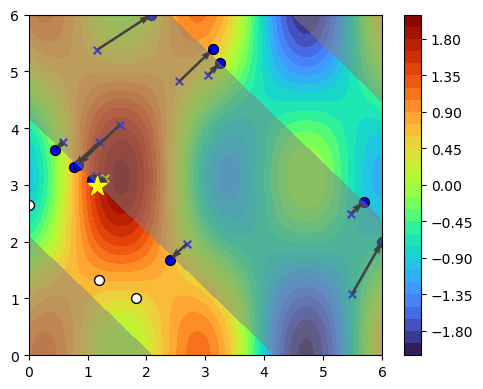

In [32]:
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float()
Y = objective_function(X).numpy().reshape(X1.shape)

plt.figure(figsize=(5, 4))

contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')
plt.colorbar(contour)
for i in range(len(train_X)):
    if constraint_function(train_X[i]).item() > 0: 
        plt.scatter(train_X[i, 0], train_X[i, 1], c='blue', s=30, marker='x', 
                    label='Infeasible Original' if i == 0 else "")
        plt.scatter(train_X_proj[i, 0], train_X_proj[i, 1], c='blue', edgecolor='black', s=50, 
                    label='Projected Feasible' if i == 0 else "")
        plt.quiver(
            train_X[i, 0], train_X[i, 1],
            train_X_proj[i, 0] - train_X[i, 0], train_X_proj[i, 1] - train_X[i, 1],
            angles='xy', scale_units='xy', scale=1, color='black', width=0.007,
            label='Projection Path' if i == 0 else ""
        )
    else: 
        plt.scatter(train_X[i, 0], train_X[i, 1], c='white', s=50, edgecolor='black', 
                    label='Originally Feasible' if i == 0 else "")

best_idx = train_Y.argmax()
best_orig_feasible = constraint_function(train_X[best_idx]).item() <= 0
if best_orig_feasible:
    plt.scatter(train_X_proj[best_idx, 0], train_X_proj[best_idx, 1], c='white', s=200, marker='*', 
                label='Best Point (Originally Feasible)')
else:
    plt.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='yellow', s=30, marker='x')
    plt.scatter(train_X_proj[best_idx, 0], train_X_proj[best_idx, 1], c='yellow', s=200, marker='*', zorder=3)
    plt.quiver(
        train_X[best_idx, 0], train_X[best_idx, 1],
        train_X_proj[best_idx, 0] - train_X[best_idx, 0], train_X_proj[best_idx, 1] - train_X[best_idx, 1],
        angles='xy', scale_units='xy', scale=1, color='black', width=0.007
    )

Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)

plt.tight_layout()

total_points = train_X.size(0)
print(f"Total number of points: {total_points}")
feasible_count = torch.sum(constraint_function(train_X_proj).squeeze() <= 0).item()
print(f"Number of points inside the feasible region (after projection): {feasible_count}")
orig_feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
print(f"Number of originally feasible points: {orig_feasible_count}")
print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X_proj[torch.argmax(train_Y)].tolist()}")
print(f"Best point was originally feasible: {best_orig_feasible}")

plt.show()